In [1]:
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp
from typing import Tuple, NamedTuple, Optional
from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.dct import colxfm
from cued_sf2_lab.lbt import pot_ii
from scipy.optimize import minimize
from simple_lbt_functions import *
from math import floor, ceil
from sys import stdout as so
from bisect import bisect
from itertools import groupby
from svdeg import *
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# your code here
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

X = bridge.copy()
X = X-128.0

In [3]:
Y = lbt(X)

In [4]:
N = 8
Yr = regroup(Y,N)

In [88]:
table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

In [89]:
table = table/16

In [90]:
c1 = 0.9
c2 = 1-c1

mat = np.ones_like(table)
table = table * c1 + mat * c2


In [91]:
def freq_quantise(Yr, table, qstep,bits = 49000):
    table = qstep * table
    Yq = np.zeros(Yr.shape)
    size = 256//8
    for i in range(8):
        for j in range(8):
            Yq[i*size:(i+1)*size,j*size:(j+1)*size] = quantise(Yr[i*size:(i+1)*size,j*size:(j+1)*size],step = table[i,j],rise1 = table[i,j])
    return Yq

In [99]:
Yq = freq_quantise(Yr,table,qstep = 35)

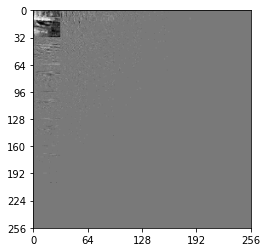

In [100]:
fig, ax = plt.subplots()
plot_image(Yq,ax = ax)

In [101]:
print(bpp(Yq)*Yq.size)

m, n = Yr.shape
N_m, N_n = N, N
Z = Yq.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
Z = Z.transpose((1, 0, 3, 2))                # permute them
Z = Z.reshape(m, n) 

Y_ = Z
Z = ilbt(Y_)
print(bpp(X)*X.size)

60458.62766935364
502517.2929232727


In [102]:
RMS = np.std(Z - X)
print(RMS)
ssim_index = ssim(X, Z, data_range=Z.max() - Z.min())
psnr_value = psnr(X, Z, data_range=Z.max() - Z.min())
print("SSIM:", ssim_index)
print("PSNR:", psnr_value)

12.932612614841513
SSIM: 0.7759223066049808
PSNR: 26.959701262488636


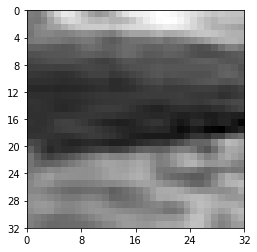

In [103]:
fig, ax = plt.subplots()
plot_image(Z[128:160,128:160],ax = ax)

In [104]:
step = 28
Yq1 = quantise(Y,step,rise1 = step)
print(bpp(Yq1)*Yq1.size)

62370.61988688865


10.343443905395013
SSIM: 0.8470413776385136
PSNR: 28.900065082836388


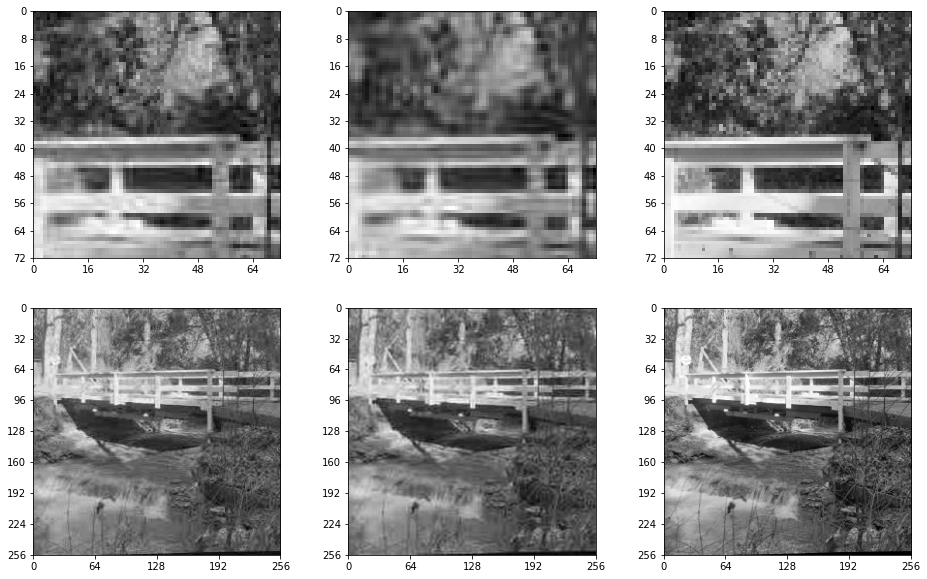

In [105]:
ZZ = ilbt(Yq1)
fig, axs = plt.subplots(2,3,figsize = (16,10))

plot_image(ZZ[28:100,128:200],ax = axs[0,0])
plot_image(Z[28:100,128:200],ax = axs[0,1])
plot_image(X[28:100,128:200],ax = axs[0,2])

plot_image(ZZ,ax = axs[1,0])
plot_image(Z,ax = axs[1,1])
plot_image(X,ax = axs[1,2])
RMS = np.std(ZZ - X)
print(RMS)
ssim_index = ssim(X, ZZ, data_range=Z.max() - Z.min())
psnr_value = psnr(X, ZZ, data_range=Z.max() - Z.min())
print("SSIM:", ssim_index)
print("PSNR:", psnr_value)

In [106]:
vlc, headers = lbtenc(X,17.0)
Z = lbtdec(vlc,17)

Forward 8 x 8 DCT
Quantising to step size of 17.0
Generating huffcode and ehuf using default tables
Coding rows
Bits for coded image = 114791
Generating huffcode and ehuf using default tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT



13.275592557012962


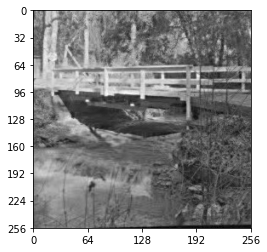

In [16]:
fig, ax = plt.subplots()
plot_image(Z,ax = ax)
RMS = np.std(Z - X)
print(RMS)

In [17]:
ssim_index = ssim(bridge, Z, data_range=Z.max() - Z.min())
psnr_value = psnr(bridge, Z, data_range=Z.max() - Z.min())
print("SSIM:", ssim_index)
print("PSNR:", psnr_value)

SSIM: 0.8894665137543395
PSNR: 25.671860693561825
